In [1]:
import torch
import numpy as np
import sklearn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from tqdm import tqdm
from PIL import Image

import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from torchvision.transforms.functional import InterpolationMode
from torchvision.models import resnet50, efficientnet_b0
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim import Adam
from torch import nn

!pip install torchensemble
from torchensemble import BaggingClassifier
from torchensemble.utils.logging import set_logger

In [2]:
!unzip "/content/drive/MyDrive/Datasets/plant-seedlings-classification.zip";

Archive:  /content/drive/MyDrive/Datasets/plant-seedlings-classification.zip
replace plant-seedlings-classification/test/Sugar beet/0021e90e4.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.classes.sort()
        self.images = []
        self.labels = []
        self.transform = transform

        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            images = os.listdir(class_dir)
            for image_name in images:
                self.images.append(os.path.join(class_dir, image_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [4]:
'''
 Объявляем значения переменных
'''
batch_size = 64
image_shape = (3, 224, 224)
classes = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet"
]
num_classes = len(classes)

In [58]:
'''
 Создаём список аугментаций, импортируем данные и разбиваем на обучающую, валидационную и тестовую выборки,
 создаём загрузчики данных для выборок.
'''
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((250, 250), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), scale=(0.7, 1.3)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_data_dir = "/content/plant-seedlings-classification/train/"
test_data_dir = "/content/plant-seedlings-classification/test/"
valid_data_dir = "/content/plant-seedlings-classification/valid/"

train_dataset = ImageFolderDataset(train_data_dir, transform=transform)
valid_dataset = ImageFolderDataset(valid_data_dir, transform=transform)
test_dataset = ImageFolderDataset(test_data_dir, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [59]:
'''
Инициализируем предобученную модель ResNet после чего замораживаем первые 45 слоёв
и последний полносвязный слой заменяем на полносвязный слой с количеством выходов
раввным количеству наших классов
'''
resnet = resnet50(pretrained=True)
# Замораживаем все слои
for param in resnet.parameters():
  param.requires_grad = False
num_layers = len(list(resnet.children()))
print('Всего слоёв', num_layers)

# Размораживаем последние 3 слоя
for param in resnet.layer4.parameters():
    param.requires_grad = True

# Заменяем последний полносвязный слой
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(classes))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Всего слоёв 10


In [60]:
# Загрузка предобученной модели
effnet = models.efficientnet_b0(pretrained=True)
half_layers = len(list(effnet.parameters())) // 2
# Заморозка всех параметров слоев
for idx, param in enumerate(effnet.parameters()):
  if idx < half_layers :
    param.requires_grad = False

# Замена последнего слоя
effnet.classifier = nn.Linear(in_features=1280, out_features=len(classes))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
'''
 Объявляем класс для создания базовой модели, которые могут быть использованы в последствии для стэкинга и бэгинга
'''
class PytorchModel(sklearn.base.BaseEstimator):
    def __init__(self, net, optim_type, optim_params, loss_fn, classes_,
                 epochs, image_shape, pretrained_path=None, model_name=None, batch_size=32,
                 cuda=False):
        self.net = net
        self.optim_type = optim_type
        self.optim_params = optim_params
        self.loss_fn = loss_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.cuda = cuda
        self.classes_ = classes_
        self.pretrained_path = pretrained_path
        self.model_name = model_name

    # Описываем функцию для обучения модели
    def fit(self, train_loader, valid_loader=None):
        if self.cuda:
            self.net.cuda()
        if self.pretrained_path:
          self.net.load_state_dict(torch.load(self.pretrained_path))
        self.optim = self.optim_type(self.net.parameters(), **self.optim_params)
        self.net.train()
        train_accuracy_list = []
        valid_accuracy_list = []
        loss_list = []
        print(f"---------------Start Training {self.model_name}----------------")
        for epoch in tqdm(range(self.epochs)):
            train_samples_count = 0
            true_train_samples_count = 0
            valid_samples_count = 0
            true_valid_samples_count = 0
            valid_accuracy = None
            for x, y in train_loader:
                if self.cuda:
                    x = x.cuda()
                    y = y.cuda()
                y_pred = self.net(x)
                loss = self.loss_fn(y_pred, y)
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()
                y_pred = y_pred.argmax(dim=1, keepdim=False)
                true_classified = (y_pred == y).sum().item()
                true_train_samples_count += true_classified
                train_samples_count += len(x)
            train_accuracy = true_train_samples_count / train_samples_count

            if valid_loader:
              for x, y in valid_loader:
                if self.cuda:
                  x = x.cuda()
                  y = y.cuda()
                y_pred = self.net(x)
                y_pred = y_pred.argmax(dim=1, keepdim=False)
                true_classified = (y_pred == y).sum().item()
                true_valid_samples_count += true_classified
                valid_samples_count += len(x)
              valid_accuracy = true_valid_samples_count / valid_samples_count


            train_accuracy_list.append(train_accuracy)
            valid_accuracy_list.append(valid_accuracy)
            loss_list.append(loss.detach().cpu().numpy())
            torch.save(self.net.state_dict(), "/content/drive/MyDrive/Models/plants-seedlings/" + self.model_name + str(epoch) + ".pt")
            print(f"Epoch {epoch},Train accuracy: {train_accuracy}, Valid accuracy: {valid_accuracy}, Loss: {loss}")
        print("---------------End Training--------------------")
        return train_accuracy_list, valid_accuracy_list, loss_list

    # Описываем функцию для предсказания вероятностей классов
    def predict_proba(self, test_loader):
        self.net.eval()
        predictions = []
        for x_batch, y_batch in tqdm(test_loader):
            if self.cuda:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()
            y_pred = self.net(x_batch)
            predictions.append(y_pred.detach().cpu().numpy())
        predictions = np.concatenate(predictions)
        return predictions

    # Описываем функцию для предсказания класса
    def predict(self, test_loader):
        predictions = self.predict_proba(test_loader)
        predictions = predictions.argmax(axis=1)
        return predictions


In [62]:
# Инициализируем базовые модели
base_models = [PytorchModel(net=resnet, optim_type=Adam, epochs=0, optim_params={"lr": 1e-3}, loss_fn=nn.CrossEntropyLoss(),
                            pretrained_path="/content/drive/MyDrive/Models/plants-seedlings/ResNet9.pt", model_name="ResNet", batch_size=batch_size, cuda=True, image_shape=image_shape, classes_=classes),
               PytorchModel(net=effnet, optim_type=Adam, epochs=0, optim_params={"lr": 1e-3}, loss_fn=nn.CrossEntropyLoss(),
                            pretrained_path="/content/drive/MyDrive/Models/plants-seedlings/EfficientNet2.pt", model_name="EfficientNet", batch_size=batch_size, cuda=True, image_shape=image_shape, classes_=classes)
]

---------------Start Training ResNet----------------


0it [00:00, ?it/s]

---------------End Training--------------------


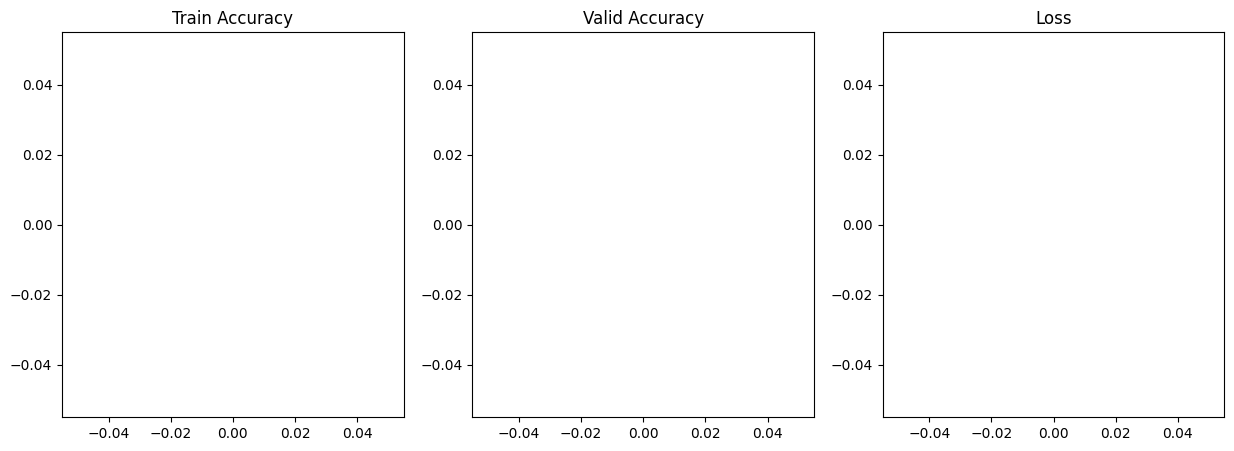

---------------Start Training EfficientNet----------------


0it [00:00, ?it/s]

---------------End Training--------------------


In [63]:
# Создание сетки с len(base_models) строкой и 3 столбцами для графиков
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Обучаем нашу модель
for model in base_models:

  train_accuracy_list, valid_accuracy_list, loss_list = model.fit(train_loader, valid_loader)
  epoch_list = [i for i in range(len(train_accuracy_list))]
  # Построение графика train_accuracy_list
  axs[0].plot(epoch_list, train_accuracy_list)
  axs[0].set_title('Train Accuracy')

  # Построение графика valid_accuracy_list
  axs[1].plot(epoch_list, valid_accuracy_list)
  axs[1].set_title('Valid Accuracy')

  # Построение графика loss_list
  axs[2].plot(epoch_list, loss_list)
  axs[2].set_title('Loss')

  # Отображение графиков
  plt.show()

In [64]:
def get_results(model, model_name, valid_loader, valid_labels, df):
  # Получаем предсказания на тестовой выборке и считаем значения метрик
  predictions = model.predict(valid_loader)
  accuracy = accuracy_score(predictions, valid_labels)
  f1 = f1_score(predictions, valid_labels, average='macro')
  recall = recall_score(predictions, valid_labels, average='macro')
  precision = precision_score(predictions, valid_labels, average='macro')

  df = df.append({'Model name': model_name, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall, 'Precision': precision}, ignore_index=True)

  cm = confusion_matrix(predictions, valid_labels)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted labels")
  plt.ylabel("True labels")
  plt.show()
  return df

In [65]:
# Создание dataframe для построения графика значений метрик
df = pd.DataFrame(columns=['Model name', 'Accuracy', 'F1', 'Recall', 'Precision'])

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6/6 [00:11<00:00,  1.90s/it]
<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': mo

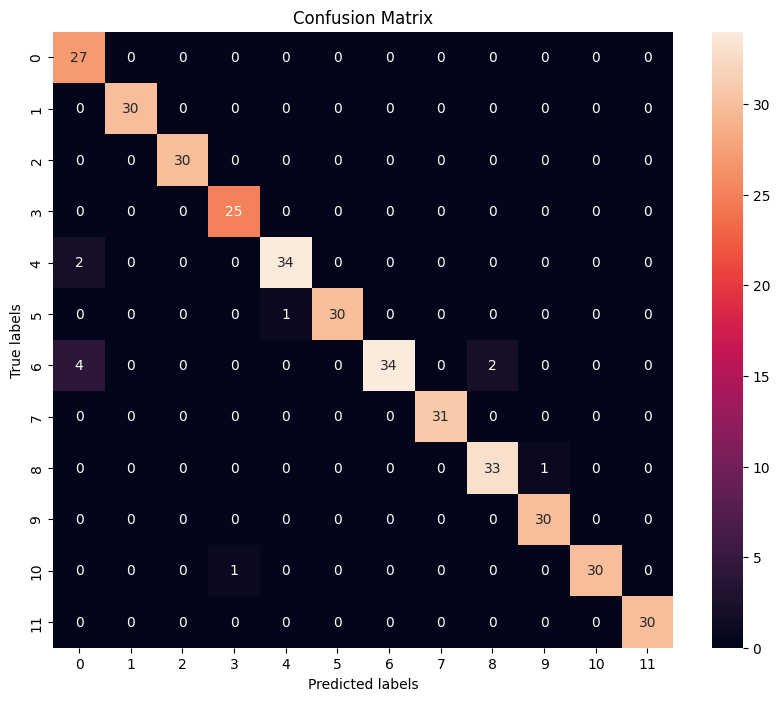

In [66]:
df = get_results(base_models[0], base_models[0].model_name, valid_loader, valid_dataset.labels, df)

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6/6 [00:11<00:00,  1.85s/it]
<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': mo

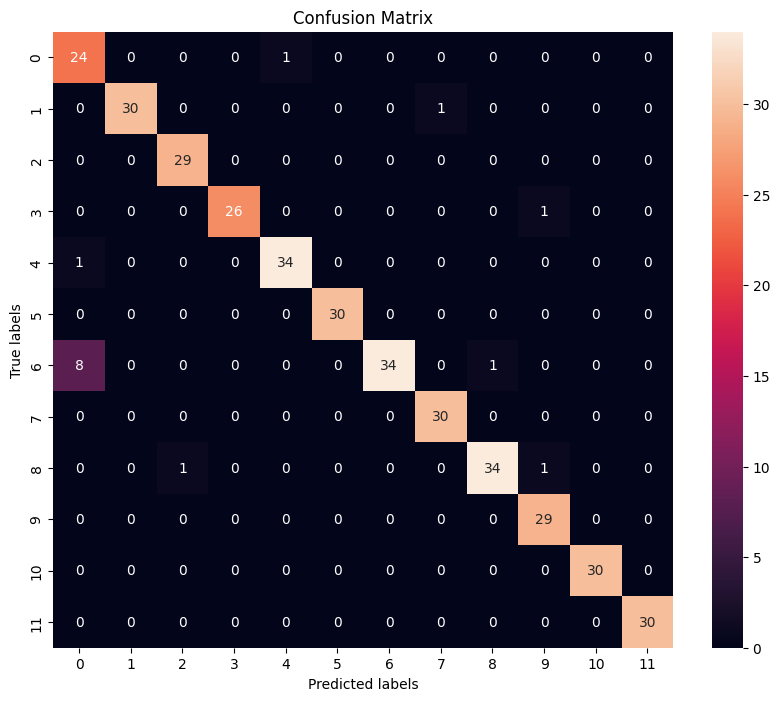

In [67]:
df = get_results(base_models[1], base_models[1].model_name, valid_loader, valid_dataset.labels, df)

In [68]:
df.head()

,Model name,Accuracy,F1,Recall,Precision
0,ResNet,0.970667,0.972033,0.975043,0.971812
1,EfficientNet,0.960000,0.961495,0.966440,0.961669


In [69]:
meta_labels_train = np.zeros((len(train_dataset.labels), len(base_models) * num_classes))
meta_labels_valid = np.zeros((len(valid_dataset.labels), len(base_models) * num_classes))

for i, model in enumerate(base_models):
    model_probs_train = model.predict_proba(train_loader)
    model_probs_valid = model.predict_proba(valid_loader)

    meta_labels_train[:, i*num_classes:(i+1)*num_classes] = model_probs_train
    meta_labels_valid[:, i*num_classes:(i+1)*num_classes] = model_probs_valid

  0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


In [70]:
meta_model = RandomForestClassifier(n_estimators=200, max_depth=8)
meta_model.fit(meta_labels_train, train_dataset.labels)

RandomForestClassifier(max_depth=8, n_estimators=200)

<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': model_name, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall, 'Precision': precision}, ignore_index=True)


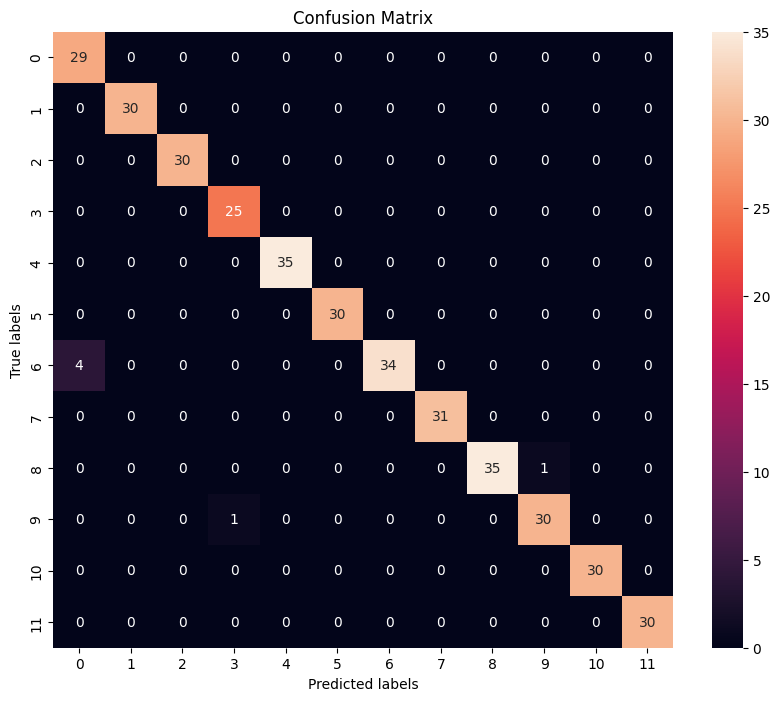

In [71]:
df = get_results(meta_model, 'Stacking with Rforest', meta_labels_valid, valid_dataset.labels, df)

In [72]:
df.head()

,Model name,Accuracy,F1,Recall,Precision
0,ResNet,0.970667,0.972033,0.975043,0.971812
1,EfficientNet,0.960000,0.961495,0.966440,0.961669
2,Stacking with Rforest,0.984000,0.984498,0.986225,0.984006


In [79]:
params = {
    'objective': 'multi:softmax',
    'num_class': 12,
    'learning_rate': 0.001,
}

xgb_model = xgb.XGBClassifier(**params)

In [83]:
xgb_model.fit(meta_labels_train, train_dataset.labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=12,
              num_parallel_tree=None, objective='multi:softmax', ...)

<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': model_name, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall, 'Precision': precision}, ignore_index=True)


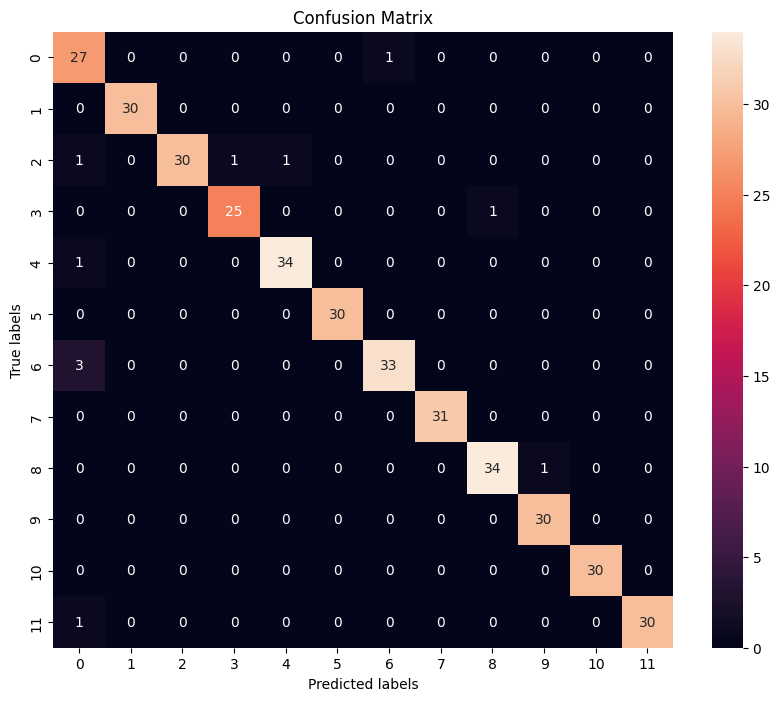

In [85]:
df = get_results(xgb_model, 'Stacking with XGB', meta_labels_valid, valid_dataset.labels, df)

In [86]:
df.head()

,Model name,Accuracy,F1,Recall,Precision
0,ResNet,0.970667,0.972033,0.975043,0.971812
1,EfficientNet,0.960000,0.961495,0.966440,0.961669
2,Stacking with Rforest,0.984000,0.984498,0.986225,0.984006
3,Stacking with XGB,0.970667,0.971008,0.971848,0.971742


In [87]:
# Задаем пространство поиска гиперпараметров для XGBClassifier
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Задаем пространство поиска гиперпараметров для RandomForestClassifier
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Создаем объект RandomizedSearchCV для XGBClassifier
xgb_random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(),
    param_distributions=xgb_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Создаем объект RandomizedSearchCV для RandomForestClassifier
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=rf_params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [88]:
# Обучаем XGBClassifier
xgb_random_search.fit(meta_labels_train, train_dataset.labels)

# Обучаем RandomForestClassifier
rf_random_search.fit(meta_labels_train, train_dataset.labels)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 10, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [89]:
best_xgb = xgb.XGBClassifier(**xgb_random_search.best_params_)
best_xgb.fit(meta_labels_train, train_dataset.labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': model_name, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall, 'Precision': precision}, ignore_index=True)


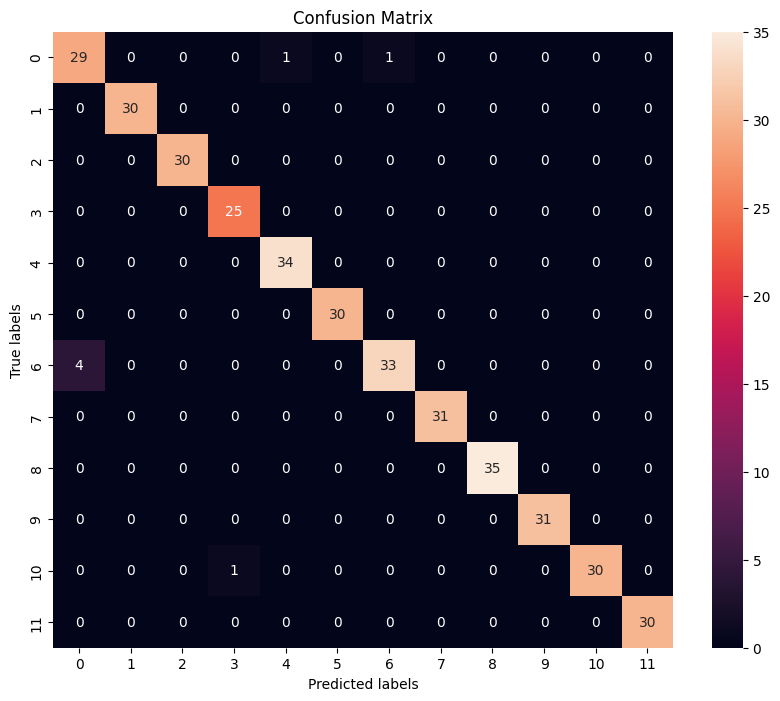

In [90]:
df = get_results(best_xgb, 'Best XGB', meta_labels_valid, valid_dataset.labels, df)

In [91]:
best_rforest = RandomForestClassifier(**rf_random_search.best_params_)
best_rforest.fit(meta_labels_train, train_dataset.labels)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=20, max_features='auto', min_samples_leaf=4)

<ipython-input-64-2be958d17850>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model name': model_name, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall, 'Precision': precision}, ignore_index=True)


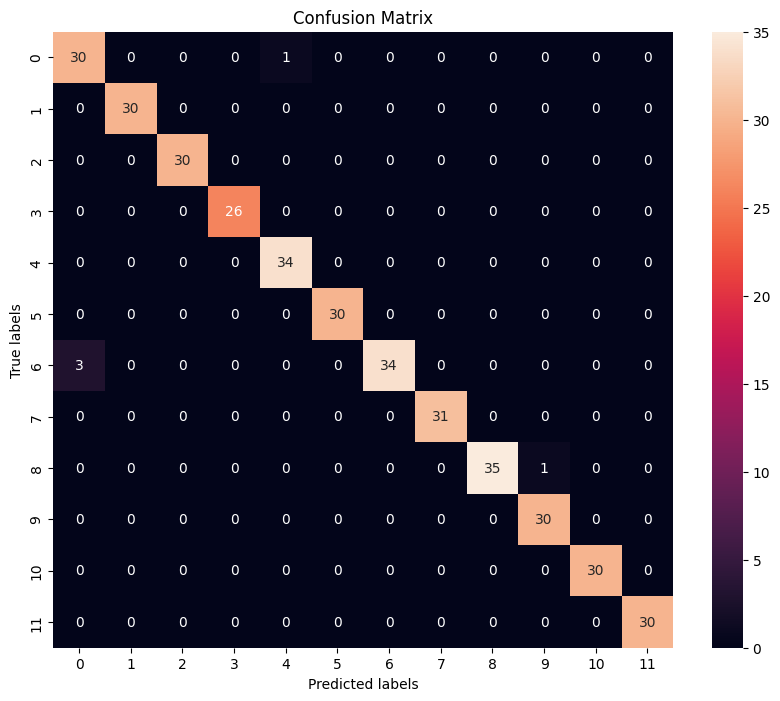

In [92]:
df = get_results(best_rforest, 'Best Rforest', meta_labels_valid, valid_dataset.labels, df)

In [94]:
df.head(5)

,Model name,Accuracy,F1,Recall,Precision
0,ResNet,0.970667,0.972033,0.975043,0.971812
1,EfficientNet,0.960000,0.961495,0.966440,0.961669
2,Stacking with Rforest,0.984000,0.984498,0.986225,0.984006
3,Stacking with XGB,0.970667,0.971008,0.971848,0.971742
4,Best XGB,0.981333,0.982111,0.982926,0.981862


In [96]:
submission = pd.DataFrame(columns=['file', 'species'])

In [98]:
classes_dict = {
    0: "Black-grass",
    1: "Charlock",
    2: "Cleavers",
    3: "Common Chickweed",
    4: "Common wheat",
    5: "Fat Hen",
    6: "Loose Silky-bent",
    7: "Maize",
    8: "Scentless Mayweed",
    9: "Shepherds Purse",
    10: "Small-flowered Cranesbill",
    11: "Sugar beet"
}

In [103]:
meta_labels_test = np.zeros((len(test_dataset.labels), len(base_models) * num_classes))

for i, model in enumerate(base_models):
    model_probs_test = model.predict_proba(test_loader)
    meta_labels_test[:, i*num_classes:(i+1)*num_classes] = model_probs_test

predictions = best_xgb.predict(meta_labels_test)
pred_class = [classes_dict[x] for x in predictions]
images_names = [name.replace('/content/plant-seedlings-classification/test/Sugar beet/', '') for name in test_dataset.images]
submission['file'] = images_names
submission['species'] = pred_class

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


In [104]:
submission.head()

,file,species
0,8db450ce3.png,Common Chickweed
1,3526b05cc.png,Scentless Mayweed
2,75cb95e91.png,Charlock
3,827279bad.png,Scentless Mayweed
4,f1e87cba7.png,Loose Silky-bent


In [105]:
submission.to_csv('submission.csv', index=False)